# 컴퓨팅사고와 데이터분석 기초

### 202501-GED6003

## 기말고사 대체과제

### <딥러닝을 통한 드론의 동역학 모델링 학습과 위치 및 자세 추정>

인하대학교 항공우주공학과 12200569 김찬영

# Initial Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyulog import ULog
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm             import tqdm
from sklearn.manifold import TSNE
from PIL              import Image

from scipy.interpolate import interp1d

In [42]:
ulg_file_path = "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\drone_data.ulg"
ulog = ULog(ulg_file_path)
dataframes = {}

for dataset in ulog.data_list:
    topic_name = dataset.name
    data = pd.DataFrame(dataset.data)
    dataframes[topic_name] = data

# 각 토픽의 이름과 열 정보 확인
# for topic, df in dataframes.items():
#     print(f"Topic: {topic}, Columns: {df.columns.tolist()}")

In [43]:
def get_data_from_ulog(topic, data_name):
    """
    특정 topic에서 데이터를 가져와 시간 데이터와 적분 결과를 계산
    
    Parameters:
        topic (str): ulog에서 가져올 topic 이름
        data_name (str): topic에서 가져올 데이터의 이름 (key)
    
    Returns:
        tuple: 데이터 값, 시간 데이터 (초 단위), 적분 결과
    """
    dataset = ulog.get_dataset(topic)
    data = dataset.data[data_name]
    
    # 시간 데이터 계산
    time_data = dataset.data['timestamp'] / 1e6  # 마이크로초 -> 초 변환
    
    return data, time_data

def euler_integral(data, time_data):
    dt = np.diff(time_data)  # 시간 간격 계산
    dt = np.insert(dt, 0, 0)  # 첫 번째 간격을 0으로 추가
    
    # 데이터 적분 (오일러 적분)
    integral = np.cumsum(data * dt) 
    return integral

def get_data_time_integral(topic, data_name):
    data, time_data = get_data_from_ulog(topic, data_name)
    integral = euler_integral(data, time_data)
    return data, time_data, integral

# Raw data
accel_x_raw, time_data_accel, velocity_x_raw = get_data_time_integral('sensor_accel', 'x')
accel_y_raw, _, velocity_y_raw = get_data_time_integral('sensor_accel', 'y')
accel_z_raw, _, velocity_z_raw = get_data_time_integral('sensor_accel', 'z')

gyro_x_raw, time_data_gyro, roll_raw = get_data_time_integral('sensor_gyro', 'x')
gyro_y_raw, _, pitch_raw = get_data_time_integral('sensor_gyro', 'y')
gyro_z_raw, _, yaw_raw = get_data_time_integral('sensor_gyro', 'z')

gps_lat, time_data_gps= get_data_from_ulog('sensor_gps', 'lat')
gps_lon, _ = get_data_from_ulog('sensor_gps', 'lon')
gps_alt, _ = get_data_from_ulog('sensor_gps', 'alt')
gps_vn, _ = get_data_from_ulog('sensor_gps', 'vel_n_m_s')
gps_ve, _ = get_data_from_ulog('sensor_gps', 'vel_e_m_s')
gps_vd, _ = get_data_from_ulog('sensor_gps', 'vel_d_m_s')

baro_pressure, time_data_baro = get_data_from_ulog('sensor_baro', 'pressure')
baro_temperature, _ = get_data_from_ulog('sensor_baro', 'temperature')

mag_x, time_data_mag = get_data_from_ulog('sensor_mag', 'x')
mag_y, _ = get_data_from_ulog('sensor_mag', 'y')
mag_z, _ = get_data_from_ulog('sensor_mag', 'z')

# Sensor filtered data
# accel_x_filtered, time_data_filtered, velocity_x_filtered = get_data_time_integral('sensor_combined', 'accelerometer_m_s2[0]')
# accel_y_filtered, _, velocity_y_filtered = get_data_time_integral('sensor_combined', 'accelerometer_m_s2[1]')
# accel_z_filtered, _, velocity_z_filtered = get_data_time_integral('sensor_combined', 'accelerometer_m_s2[2]')

# gyro_x_filtered, _, roll_filtered = get_data_time_integral('sensor_combined', 'gyro_rad[0]')
# gyro_y_filtered, _, pitch_filtered = get_data_time_integral('sensor_combined', 'gyro_rad[1]')
# gyro_z_filtered, _, yaw_filtered = get_data_time_integral('sensor_combined', 'gyro_rad[2]')

# local position data
local_position_data = ulog.get_dataset('vehicle_local_position')
velocity_x_local = local_position_data.data['vx']
velocity_y_local = local_position_data.data['vy']
velocity_z_local = local_position_data.data['vz']
time_data_local = local_position_data.data['timestamp'] / 1e6  # 마이크로초 -> 초 변환

## Raw data Import

In [44]:
file_path = [
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AccelX.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AccelY.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AccelZ.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\GyroX.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\GyroY.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\GyroZ.csv"
]

# 파일 경로를 반으로 나누어 각 배열에 저장
num_files = len(file_path)
half_index = num_files // 2  # 파일 수의 절반

acc_raw_data_list = []
gyro_raw_data_list = []
imu_target_time_list = []

for i in range(half_index):
    data = pd.read_csv(file_path[i], delimiter=',', usecols=[1])
    acc_raw_data_list.append(data.values)

for i in range(half_index, num_files):
    data = pd.read_csv(file_path[i], delimiter=',', usecols=[1])
    gyro_raw_data_list.append(data.values)

data = pd.read_csv(file_path[i], delimiter=',', usecols=[0])
data = data.iloc[:, 0].str.replace('초', '').astype(float)
imu_target_time_list.append(data)

# 가속도 데이터와 자이로 데이터를 각각 2차원 배열로 변환
acc_raw_data = np.array(acc_raw_data_list).reshape(-1, 3)
gyro_raw_data = np.array(gyro_raw_data_list).reshape(-1, 3)
imu_target_time = np.array(imu_target_time_list).T

# 재정렬된 데이터 확인
print("Accel raw data size:", acc_raw_data.shape)
print("Gyro raw data size:", gyro_raw_data.shape)
print("Att raw time data size:", imu_target_time.shape)

Accel raw data size: (53592, 3)
Gyro raw data size: (53592, 3)
Att raw time data size: (53592, 1)


## Target data Import

In [45]:
file_path = [
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\LocalNEDVel_VX.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\LocalNEDVel_VY.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\LocalNEDVel_VZ.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AttitudeEuler_Roll.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AttitudeEuler_Pitch.csv",
    "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AttitudeEuler_Yaw.csv"
]

# 파일 경로를 반으로 나누어 각 배열에 저장
num_files = len(file_path)
half_index = num_files // 2 

vel_target_data_list = []
att_target_data_list = []
att_target_time_list = []

for i in range(half_index):
    data = pd.read_csv(file_path[i], delimiter=',', usecols=[1])
    vel_target_data_list.append(data.values)

for i in range(half_index, num_files):
    data = pd.read_csv(file_path[i], delimiter=',', usecols=[1])
    att_target_data_list.append(data.values)
    
data = pd.read_csv(file_path[i], delimiter=',', usecols=[0])
data = data.iloc[:, 0].str.replace('초', '').astype(float)
att_target_time_list.append(data)

# 가속도 데이터와 자이로 데이터를 각각 2차원 배열로 변환
vel_target_data = np.column_stack(vel_target_data_list)  # 열 방향으로 병합
att_target_data = np.column_stack(att_target_data_list)  # 열 방향으로 병합
att_target_time = np.array(att_target_time_list).T


# 재정렬된 데이터 확인
print("VelNED data size:", vel_target_data.shape)
print("AttitudeEuler data size:", att_target_data.shape)
print("Att time data size:", att_target_time.shape)

VelNED data size: (2709, 3)
AttitudeEuler data size: (5417, 3)
Att time data size: (5417, 1)


In [46]:
# Target data 지정
velocity_x_target = vel_target_data[:, 0]
velocity_y_target = vel_target_data[:, 1]
velocity_z_target = vel_target_data[:, 2]
time_vel_target = time_data_local

roll_target = att_target_data[:, 0]
pitch_target = att_target_data[:, 1]
yaw_target = att_target_data[:, 2]
time_att_target = att_target_time

print("Vel time data size:", vel_target_data.shape)
print("Att time data size:", att_target_data.shape)

Vel time data size: (2709, 3)
Att time data size: (5417, 3)


In [47]:
def plot_velocity_attitude(vel_x, vel_y, vel_z, time_data_accel, roll, pitch, yaw, time_data_gyro):
    # 결과 시각화
    plt.figure(figsize=(10, 6))

    # 속도 추정 시각화
    plt.subplot(2, 1, 1)
    plt.plot(time_data_accel, vel_x, '.-', markersize=2, linewidth=0.3, label="velocity X")
    plt.plot(time_data_accel, vel_y, '.-', markersize=2, linewidth=0.3, label="velocity Y")
    plt.plot(time_data_accel, vel_z, '.-', markersize=2, linewidth=0.3, label="velocity Z")
    plt.xlabel('time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity')
    plt.legend()
    plt.grid()

    # 자세 추정 시각화
    plt.subplot(2, 1, 2)
    plt.plot(time_data_gyro, roll*180/np.pi, '.-', markersize=2, linewidth=0.3, label="roll")
    plt.plot(time_data_gyro, pitch*180/np.pi, '.-', markersize=2, linewidth=0.3, label="pitch")
    plt.plot(time_data_gyro, yaw*180/np.pi, '.-', markersize=2, linewidth=0.3, label="yaw")
    plt.xlabel('time(s)')
    plt.ylabel('Attitude (rad)')
    plt.title('Attitude')
    plt.legend()

    plt.grid()
    plt.tight_layout()
    plt.show()

## Attitude data estimate by Complementary filter

여러가지 시도해보던 것 중 하나입니다.

보고서에는 내용상 일관성을 유지하기 위해 언급하지 않았으나, 다른 분들께 참고가 될까 하여 남겨둡니다.

In [14]:
accel_x_raw = acc_raw_data[:, 0]
accel_y_raw = acc_raw_data[:, 1]
accel_z_raw = acc_raw_data[:, 2]
gyro_x_raw = gyro_raw_data[:, 0]
gyro_y_raw = gyro_raw_data[:, 1]
gyro_z_raw = gyro_raw_data[:, 2]

time_data_imu = imu_target_time

# # 상보 필터 파라미터
# alpha = 0.985

# roll_angle = 0
# pitch_angle = 0
# yaw_angle = 0

# n = len(time_data_imu)
# roll_angles = np.zeros(n)
# pitch_angles = np.zeros(n)
# yaw_angles = np.zeros(n)

# for i in range(n):
#     accel_roll = np.arctan2(accel_y_raw[i], np.sqrt(accel_x_raw[i]**2 + accel_z_raw[i]**2))
#     accel_pitch = np.arctan2(-accel_x_raw[i], np.sqrt(accel_y_raw[i]**2 + accel_z_raw[i]**2))

#     gyro_roll_rate = gyro_x_raw[i] + gyro_y_raw[i] * np.sin(roll_angle) * np.tan(pitch_angle) + gyro_z_raw[i] * np.cos(roll_angle) * np.tan(pitch_angle)
#     gyro_pitch_rate = gyro_y_raw[i] * np.cos(roll_angle) - gyro_z_raw[i] * np.sin(roll_angle)
#     gyro_yaw_rate = gyro_y_raw[i] * np.sin(roll_angle) / np.cos(pitch_angle) + gyro_z_raw[i] * np.cos(roll_angle) / np.cos(pitch_angle)

#     gyro_roll_rate = gyro_x_raw[i]
#     gyro_pitch_rate = gyro_y_raw[i]
#     gyro_yaw_rate = gyro_z_raw[i]

#     if i > 0:
#         dt = time_data_imu[i] - time_data_imu[i-1]
#     else:
#         dt = 0 

#     roll_angle = alpha * (roll_angle + gyro_roll_rate * dt) + (1 - alpha) * accel_roll
#     pitch_angle = alpha * (pitch_angle + gyro_pitch_rate * dt) + (1 - alpha) * accel_pitch
#     yaw_angle += gyro_yaw_rate * dt 

#     roll_angles[i] = roll_angle
#     pitch_angles[i] = pitch_angle
#     yaw_angles[i] = yaw_angle


file_path_attitude = "C:\\Users\\142857\\Desktop\\4학년 1학기\\컴퓨팅사고와 데이터분석 기초\\기말 레포트\\data\\AttitudeEuler_estimated.csv"
att_comp = []

att_comp.append(pd.read_csv(file_path_attitude, delimiter=',', usecols=[1]).values.flatten())
att_comp.append(pd.read_csv(file_path_attitude, delimiter=',', usecols=[2]).values.flatten())
att_comp.append(pd.read_csv(file_path_attitude, delimiter=',', usecols=[3]).values.flatten())

att_comp_filtered = np.stack(att_comp, axis=1)
# att_comp_filtered[:, 2] = -(att_comp_filtered[:, 2] - att_comp_filtered[0, 2])

att_comp_filtered[:, 2] *= -1
att_comp_filtered[:, 2] += np.pi/3
for i in range(len(att_comp_filtered[:, 2])):
    if att_comp_filtered[i, 2] > np.pi:
        att_comp_filtered[i, 2] -= 2*np.pi


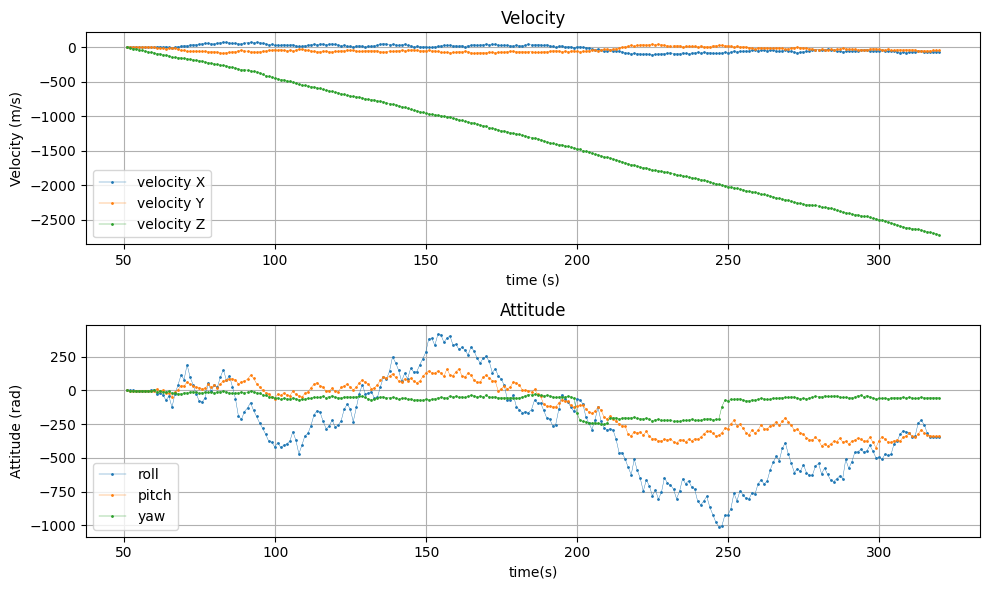

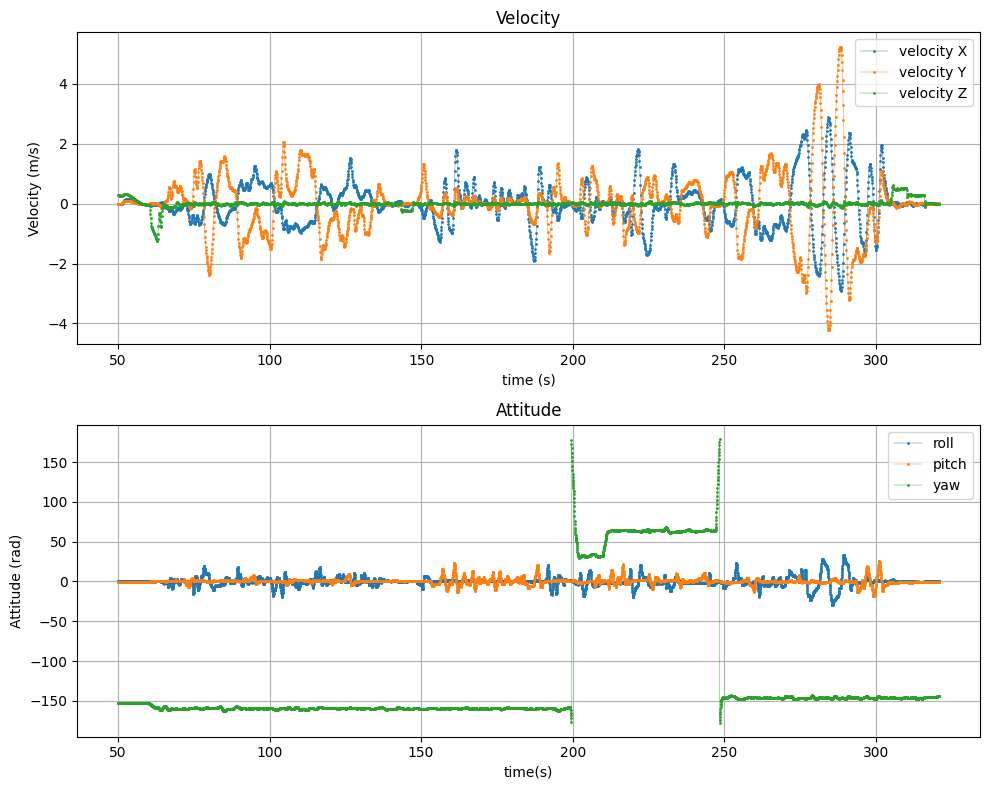

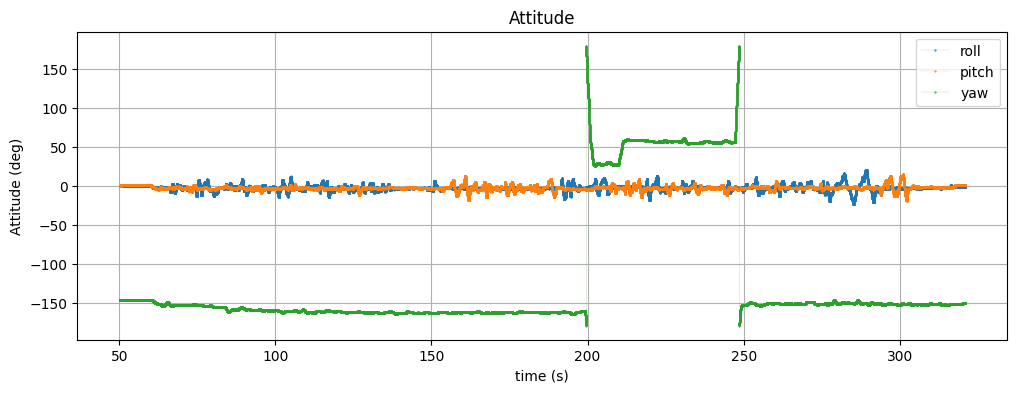

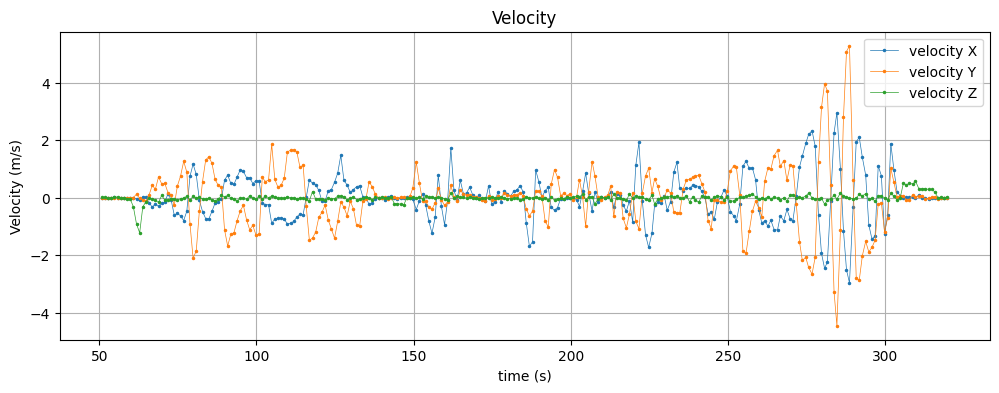

In [15]:
plot_velocity_attitude(velocity_x_raw, velocity_y_raw, velocity_z_raw, time_data_accel, roll_raw, pitch_raw, yaw_raw, time_data_gyro)
# plot_velocity_attitude(velocity_x_target, velocity_y_target, velocity_z_target, time_vel_target, roll_target, pitch_target, yaw_target, time_att_target)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(time_vel_target, velocity_x_target, '.-', markersize=2, linewidth=0.3, label="velocity X")
plt.plot(time_vel_target, velocity_y_target, '.-', markersize=2, linewidth=0.3, label="velocity Y")
plt.plot(time_vel_target, velocity_z_target, '.-', markersize=2, linewidth=0.3, label="velocity Z")
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time_att_target, roll_target*180/np.pi, '.-', markersize=2, linewidth=0.3, label="roll")
plt.plot(time_att_target, pitch_target*180/np.pi, '.-', markersize=2, linewidth=0.3, label="pitch")
plt.plot(time_att_target, yaw_target*180/np.pi, '.-', markersize=2, linewidth=0.3, label="yaw")
plt.xlabel('time(s)')
plt.ylabel('Attitude (rad)')
plt.title('Attitude')
plt.legend()

plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time_data_imu, att_comp_filtered[:, 0]*180/np.pi, '.-', markersize=1, linewidth=0.1, label="roll")
plt.plot(time_data_imu, att_comp_filtered[:, 1]*180/np.pi, '.-', markersize=1, linewidth=0.1, label="pitch")
plt.plot(time_data_imu, att_comp_filtered[:, 2]*180/np.pi, '.-', markersize=1, linewidth=0.1, label="yaw")
plt.xlabel('time (s)')
plt.ylabel('Attitude (deg)')
plt.title('Attitude')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time_data_gps, gps_vn, '.-', markersize=3, linewidth=0.5, label="velocity X")
plt.plot(time_data_gps, gps_ve, '.-', markersize=3, linewidth=0.5, label="velocity Y")
plt.plot(time_data_gps, gps_vd, '.-', markersize=3, linewidth=0.5, label="velocity Z")
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.legend()
plt.grid()

## Preprocessing

In [16]:
def data_interp1d(data, data_time, target_time):
    """
    1D 인터폴레이션을 사용하여 데이터 시간 맞추기
    
    Parameters:
        data (np.ndarray): 원본 데이터
        data_time (np.ndarray): 데이터의 시간 배열
        target_time (np.ndarray): 맞추려는 타겟 시간 배열
    
    Returns:
        np.ndarray: 타겟 시간에 맞춘 데이터
    """
    data_interp = interp1d(data_time, data, axis=0, fill_value="extrapolate")
    data_sync = data_interp(target_time)  # 공통 시간에 맞춘 데이터
    return data_sync

def preprocess_sensor_data(topic_data_pairs, target_time):
    data_list = []
    
    for topic, data_name_list in topic_data_pairs.items():
        for data_name in data_name_list:
            if topic == 'sensor_accel':
                if data_name == 'x':
                    data = acc_raw_data[:, 0]
                elif data_name == 'y':
                    data = acc_raw_data[:, 1]
                elif data_name == 'z':
                    data = acc_raw_data[:, 2]
                
                time_data = imu_target_time.flatten()
                data_sync = data_interp1d(data, time_data, target_time)
                data_list.append(data_sync)
                print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")

            elif topic == 'sensor_gyro':
                if data_name == 'x':
                    data = gyro_raw_data[:, 0]
                elif data_name == 'y':
                    data = gyro_raw_data[:, 1]
                elif data_name == 'z':
                    data = gyro_raw_data[:, 2]
                
                time_data = imu_target_time.flatten()
                data_sync = data_interp1d(data, time_data, target_time)
                data_list.append(data_sync)
                print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")

            elif topic == 'attitude_est':
                for i in range(np.shape(att_comp_filtered)[1]):
                    data = att_comp_filtered[:, i]
                    time_data = imu_target_time.flatten()
                    data_sync = data_interp1d(data, time_data, target_time)
                    data_list.append(data_sync)
                    print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")

            # elif data_name in ['vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s']:
            #     data, time_data = get_data_from_ulog(topic, data_name)
            #     data_sync = data_interp1d(data, time_data, target_time)
            #     data_sync_prev = np.roll(data_sync, shift=1)  # 이전 샘플 값
            #     data_sync_prev[0] = data_sync[0]  # 첫 번째 값은 현재 값으로 유지
            #     data_list.append(data_sync_prev)  # 이전 샘플 데이터 추가
            #     data_list.append(data_sync)
            #     print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")
            
            elif data_name in ['lat', 'lon', 'alt']:
                data, time_data = get_data_from_ulog(topic, data_name)
                data_sync = data_interp1d(data, time_data, target_time)
                data_sync_prev = np.roll(data_sync, shift=1)  # 이전 샘플 값
                data_sync_prev[0] = data_sync[0]  # 첫 번째 값은 현재 값으로 유지
                data_list.append(data_sync_prev)  # 이전 샘플 데이터 추가
                data_list.append(data_sync)
                print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")

            else: 
                data, time_data = get_data_from_ulog(topic, data_name)
                data_sync = data_interp1d(data, time_data, target_time)
                data_list.append(data_sync)  # 각 보간된 데이터를 리스트에 추가
                print(f"{topic} : {data_name}, {np.shape(data_sync)}, {np.shape(data_list)}")
    
    
    # input_matrix = np.vstack(data_list).T  # 리스트를 하나의 2차원 배열로 결합
    input_matrix = np.column_stack(data_list)
    return input_matrix

input_data_pairs = {
    "sensor_accel": ['x', 'y', 'z'],
    "sensor_gyro": ['x', 'y', 'z'],
    "sensor_gps": ['vel_m_s','vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s', 
                   's_variance_m_s', 'c_variance_rad', 'noise_per_ms', 'cog_rad',
                   'eph', 'epv', 'hdop', 'vdop'],
    "sensor_mag": ['x', 'y', 'z'],
    "attitude_est": ['complement']
}

# Deep Learning Model

In [18]:
# 모델 정의
class droneNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(droneNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.4)
        self.layer2 = nn.Linear(hidden_size, hidden_size//2)
        self.layer3 = nn.Linear(hidden_size//2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

## Velocity Model

In [48]:
input_data_vel = preprocess_sensor_data(input_data_pairs, time_vel_target)

velocity_target_vel = np.vstack((velocity_x_target, velocity_y_target, velocity_z_target)).T # 2709 x 3
attitude_target_vel = np.vstack((roll_target, pitch_target, yaw_target)).T # 53592 x 3

target_data_vel = velocity_target_vel

print(f"Input data : {input_data_vel.shape}") 
print(f"Target data : {target_data_vel.shape}")  # (2709, 3)

total_size_vel = input_data_vel.shape[0]
train_size_vel = 2000  # 학습 데이터 개수

# 랜덤 시드 고정 (재현성을 위해)
# np.random.seed(42)

# 인덱스 생성 및 섞기
indices = np.arange(total_size_vel)
np.random.shuffle(indices)

# 섞인 인덱스를 기반으로 데이터 분할
train_indices = indices[:train_size_vel]  # 학습 데이터 인덱스
test_indices = indices[train_size_vel:]  # 테스트 데이터 인덱스

# 학습 데이터와 테스트 데이터 추출
train_input_vel = input_data_vel[train_indices]
train_target_vel = target_data_vel[train_indices]
test_input_vel = input_data_vel[test_indices]
test_target_vel = target_data_vel[test_indices]

# 결과 확인
print(f"Train and Test input shape: {train_input_vel.shape}, {test_input_vel.shape}")
print(f"Train and Test target shape: {train_target_vel.shape}, {test_target_vel.shape}")

sensor_accel : x, (2709,), (1, 2709)
sensor_accel : y, (2709,), (2, 2709)
sensor_accel : z, (2709,), (3, 2709)
sensor_gyro : x, (2709,), (4, 2709)
sensor_gyro : y, (2709,), (5, 2709)
sensor_gyro : z, (2709,), (6, 2709)
sensor_gps : vel_m_s, (2709,), (7, 2709)
sensor_gps : vel_n_m_s, (2709,), (8, 2709)
sensor_gps : vel_e_m_s, (2709,), (9, 2709)
sensor_gps : vel_d_m_s, (2709,), (10, 2709)
sensor_gps : s_variance_m_s, (2709,), (11, 2709)
sensor_gps : c_variance_rad, (2709,), (12, 2709)
sensor_gps : noise_per_ms, (2709,), (13, 2709)
sensor_gps : cog_rad, (2709,), (14, 2709)
sensor_gps : eph, (2709,), (15, 2709)
sensor_gps : epv, (2709,), (16, 2709)
sensor_gps : hdop, (2709,), (17, 2709)
sensor_gps : vdop, (2709,), (18, 2709)
sensor_mag : x, (2709,), (19, 2709)
sensor_mag : y, (2709,), (20, 2709)
sensor_mag : z, (2709,), (21, 2709)
attitude_est : complement, (2709,), (22, 2709)
attitude_est : complement, (2709,), (23, 2709)
attitude_est : complement, (2709,), (24, 2709)
Input data : (2709, 

Epoch [10/5000], Train Loss: 0.6767441, Val Loss: 0.4921808
Epoch [20/5000], Train Loss: 0.5812953, Val Loss: 0.4825599
Epoch [30/5000], Train Loss: 0.5305568, Val Loss: 0.4571848
Epoch [40/5000], Train Loss: 0.4378798, Val Loss: 0.3596168
Epoch [50/5000], Train Loss: 0.3145922, Val Loss: 0.2452570
Epoch [60/5000], Train Loss: 0.2475235, Val Loss: 0.2008491
Epoch [70/5000], Train Loss: 0.2203896, Val Loss: 0.1782560
Epoch [80/5000], Train Loss: 0.2017243, Val Loss: 0.1681211
Epoch [90/5000], Train Loss: 0.1901143, Val Loss: 0.1599579
Epoch [100/5000], Train Loss: 0.1851378, Val Loss: 0.1569098
Epoch [110/5000], Train Loss: 0.1732786, Val Loss: 0.1479894
Epoch [120/5000], Train Loss: 0.1671530, Val Loss: 0.1408284
Epoch [130/5000], Train Loss: 0.1641000, Val Loss: 0.1370488
Epoch [140/5000], Train Loss: 0.1661979, Val Loss: 0.1367445
Epoch [150/5000], Train Loss: 0.1660700, Val Loss: 0.1325163
Epoch [160/5000], Train Loss: 0.1605610, Val Loss: 0.1295158
Epoch [170/5000], Train Loss: 0.1

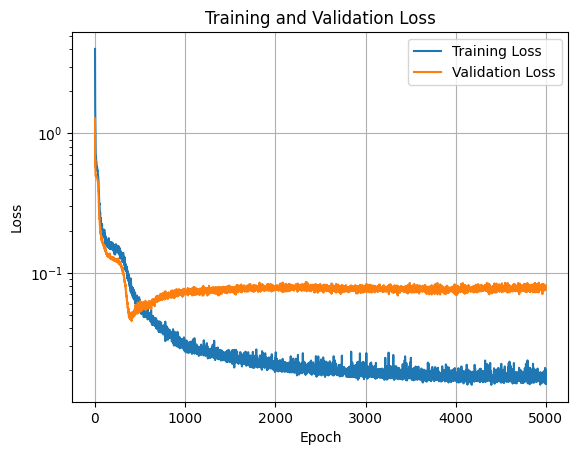

In [ ]:
# Tensor로 변환
inputs = torch.tensor(train_input_vel, dtype=torch.float32)
targets = torch.tensor(train_target_vel, dtype=torch.float32)

# Validation
validation_split = 0.2
val_size = int(validation_split * inputs.shape[0])
train_size = inputs.shape[0] - val_size

train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
train_targets, val_targets = targets[:train_size], targets[train_size:]

# 하이퍼파라미터 설정
input_size = np.shape(train_input_vel)[1]
hidden_size = 50
output_size = np.shape(train_target_vel)[1]
learning_rate = 1e-3
weight_decay = 1e-4  # L2 정규화 강도
num_epochs = 5000

# 모델, 손실 함수, 옵티마이저 초기화
velocity_model = droneNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(velocity_model.parameters(), lr=learning_rate)

batch_size = 250  # 배치 크기 설정
num_batches = train_size // batch_size  # 배치 개수 계산

# 학습 루프
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_params = None

for epoch in range(num_epochs):
    velocity_model.train()  # 모델을 학습 모드로 설정
    epoch_train_loss = 0  # 에포크별 학습 손실 초기화

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        # 배치 데이터 준비
        inputs_batch = inputs[start_idx:end_idx]
        targets_batch = targets[start_idx:end_idx]

        # 순전파
        outputs = velocity_model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 배치 손실 누적
        epoch_train_loss += loss.item()

    # 에포크별 평균 손실 저장
    epoch_train_loss /= num_batches
    train_losses.append(epoch_train_loss)

    # Validation 손실 계산
    velocity_model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        val_outputs = velocity_model(val_inputs)
        val_loss = criterion(val_outputs, val_targets).item()
        val_losses.append(val_loss)
    
    # Validation 손실이 최저일 경우 모델 파라미터 저장
    if val_loss < best_val_loss:
        best_val_epoch = epoch
        best_val_loss = val_loss
        best_model_params = velocity_model.state_dict()  # 모델의 상태 저장

    # 10 에포크마다 로그 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.7f}, Val Loss: {val_loss:.7f}')

# Best 모델 파라미터 복원
if best_model_params is not None:
    velocity_model.load_state_dict(best_model_params)
    print(f"Model restored to best validation loss at epoch {best_val_epoch+1}: {best_val_loss:.7f}")

# 학습 손실 그래프
plt.semilogy(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.semilogy(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [50]:
test_inputs_vel = torch.tensor(test_input_vel, dtype=torch.float32)
test_outputs_vel = velocity_model(test_inputs_vel)

test_targets_vel = torch.tensor(test_target_vel, dtype=torch.float32)

# 차이 계산
mse_vel = torch.mean((test_outputs_vel - test_targets_vel) ** 2).item()  # 평균 제곱 오차
mae_vel = torch.mean(torch.abs(test_outputs_vel - test_targets_vel)).item()  # 평균 절대 오차

# 결과 출력
print(f"Velocity - Mean Squared Error (MSE): {mse_vel:.4f}")
print(f"Velocity - Mean Absolute Error (MAE): {mae_vel:.4f}")

Velocity - Mean Squared Error (MSE): 0.1039
Velocity - Mean Absolute Error (MAE): 0.1758


## Attitude Model

In [51]:
input_data_att = preprocess_sensor_data(input_data_pairs, time_att_target)
target_data_att = np.vstack((roll_target, pitch_target, yaw_target)).T # 53592 x 3

print(f"Input data : {input_data_att.shape}") 
print(f"Target data : {target_data_att.shape}") 

total_size_att = input_data_att.shape[0]
train_size_att = 4000

indices = np.arange(total_size_att)
np.random.shuffle(indices)

train_indices = indices[:train_size_att]  
test_indices = indices[train_size_att:]  

train_input_att = input_data_att[train_indices]
train_target_att = target_data_att[train_indices]
test_input_att = input_data_att[test_indices]
test_target_att = target_data_att[test_indices]

print("Train input shape:", train_input_att.shape)
print("Train target shape:", train_target_att.shape)
print("Test input shape:", test_input_att.shape)
print("Test target shape:", test_target_att.shape)

sensor_accel : x, (5417, 1), (1, 5417, 1)
sensor_accel : y, (5417, 1), (2, 5417, 1)
sensor_accel : z, (5417, 1), (3, 5417, 1)
sensor_gyro : x, (5417, 1), (4, 5417, 1)
sensor_gyro : y, (5417, 1), (5, 5417, 1)
sensor_gyro : z, (5417, 1), (6, 5417, 1)
sensor_gps : vel_m_s, (5417, 1), (7, 5417, 1)
sensor_gps : vel_n_m_s, (5417, 1), (8, 5417, 1)
sensor_gps : vel_e_m_s, (5417, 1), (9, 5417, 1)
sensor_gps : vel_d_m_s, (5417, 1), (10, 5417, 1)
sensor_gps : s_variance_m_s, (5417, 1), (11, 5417, 1)
sensor_gps : c_variance_rad, (5417, 1), (12, 5417, 1)
sensor_gps : noise_per_ms, (5417, 1), (13, 5417, 1)
sensor_gps : cog_rad, (5417, 1), (14, 5417, 1)
sensor_gps : eph, (5417, 1), (15, 5417, 1)
sensor_gps : epv, (5417, 1), (16, 5417, 1)
sensor_gps : hdop, (5417, 1), (17, 5417, 1)
sensor_gps : vdop, (5417, 1), (18, 5417, 1)
sensor_mag : x, (5417, 1), (19, 5417, 1)
sensor_mag : y, (5417, 1), (20, 5417, 1)
sensor_mag : z, (5417, 1), (21, 5417, 1)
attitude_est : complement, (5417, 1), (22, 5417, 1)
atti

Epoch [10/5000], Train Loss: 0.7439107, Val Loss: 0.5723283
Epoch [20/5000], Train Loss: 0.4103974, Val Loss: 0.2495988
Epoch [30/5000], Train Loss: 0.1927540, Val Loss: 0.0703372
Epoch [40/5000], Train Loss: 0.1395437, Val Loss: 0.0634699
Epoch [50/5000], Train Loss: 0.1142490, Val Loss: 0.0614580
Epoch [60/5000], Train Loss: 0.1003591, Val Loss: 0.0995239
Epoch [70/5000], Train Loss: 0.0771114, Val Loss: 0.0995376
Epoch [80/5000], Train Loss: 0.0755366, Val Loss: 0.1018839
Epoch [90/5000], Train Loss: 0.0679156, Val Loss: 0.1015956
Epoch [100/5000], Train Loss: 0.0707261, Val Loss: 0.1226886
Epoch [110/5000], Train Loss: 0.0672568, Val Loss: 0.1143879
Epoch [120/5000], Train Loss: 0.0583531, Val Loss: 0.1198057
Epoch [130/5000], Train Loss: 0.0564747, Val Loss: 0.1489354
Epoch [140/5000], Train Loss: 0.0420675, Val Loss: 0.1341543
Epoch [150/5000], Train Loss: 0.0404429, Val Loss: 0.1560694
Epoch [160/5000], Train Loss: 0.0345748, Val Loss: 0.1330761
Epoch [170/5000], Train Loss: 0.0

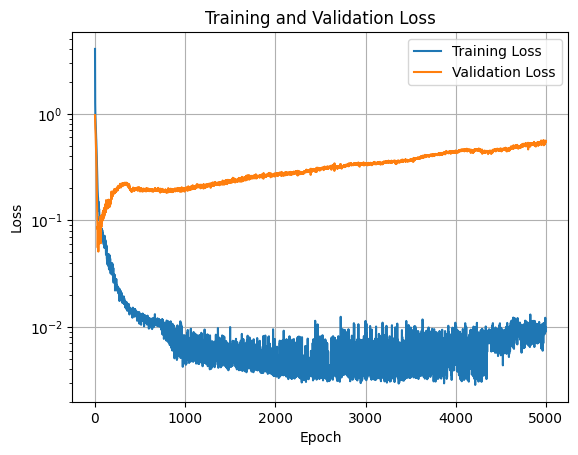

In [26]:
# Tensor로 변환
inputs = torch.tensor(train_input_att, dtype=torch.float32)
targets = torch.tensor(train_target_att, dtype=torch.float32)

# Validation
validation_split = 0.2
val_size = int(validation_split * inputs.shape[0])
train_size = inputs.shape[0] - val_size

train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
train_targets, val_targets = targets[:train_size], targets[train_size:]

# 하이퍼파라미터 설정
input_size = np.shape(train_input_att)[1]
hidden_size = 50
output_size = np.shape(train_target_att)[1]
learning_rate = 1e-3
weight_decay = 1e-4  # L2 정규화 강도
num_epochs = 5000

# 모델, 손실 함수, 옵티마이저 초기화
attitude_model = droneNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(attitude_model.parameters(), lr=learning_rate)

batch_size = 250  # 배치 크기 설정
num_batches = train_size // batch_size  # 배치 개수 계산

# 학습 루프
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_params = None

for epoch in range(num_epochs):
    attitude_model.train()  # 모델을 학습 모드로 설정
    epoch_train_loss = 0  # 에포크별 학습 손실 초기화

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        # 배치 데이터 준비
        inputs_batch = inputs[start_idx:end_idx]
        targets_batch = targets[start_idx:end_idx]

        # 순전파
        outputs = attitude_model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 배치 손실 누적
        epoch_train_loss += loss.item()

    # 에포크별 평균 손실 저장
    epoch_train_loss /= num_batches
    train_losses.append(epoch_train_loss)

    # Validation 손실 계산
    attitude_model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        val_outputs = attitude_model(val_inputs)
        val_loss = criterion(val_outputs, val_targets).item()
        val_losses.append(val_loss)
    
    # Validation 손실이 최저일 경우 모델 파라미터 저장
    if val_loss < best_val_loss:
        best_val_epoch = epoch
        best_val_loss = val_loss
        best_model_params = attitude_model.state_dict()  # 모델의 상태 저장

     # 10 에포크마다 로그 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.7f}, Val Loss: {val_loss:.7f}')

# Best 모델 파라미터 복원
if best_model_params is not None:
    attitude_model.load_state_dict(best_model_params)
    print(f"Model restored to best validation loss at epoch {best_val_epoch+1}: {best_val_loss:.7f}")

# 학습 손실 그래프
plt.semilogy(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.semilogy(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [52]:
test_inputs_att = torch.tensor(test_input_att, dtype=torch.float32)
test_outputs_att = attitude_model(test_inputs_att)

test_targets_att = torch.tensor(test_target_att, dtype=torch.float32)

# 차이 계산
mse_att = torch.mean((test_outputs_att - test_targets_att) ** 2).item()  # 평균 제곱 오차
mae_att = torch.mean(torch.abs(test_outputs_att - test_targets_att)).item()  # 평균 절대 오차

# 결과 출력
print(f"Attitude - Mean Squared Error (MSE): {mse_att:.4f}")
print(f"Attitude - Mean Absolute Error (MAE): {mae_att:.4f}")

Attitude - Mean Squared Error (MSE): 0.5567
Attitude - Mean Absolute Error (MAE): 0.4517


# Analysis

C:\Users\142857\AppData\Local\Temp\ipykernel_10156\3024383036.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_data_vel = torch.tensor(target_data_vel, dtype=torch.float32)


Velocity - Mean Squared Error (MSE): 0.0926
Velocity - Mean Absolute Error (MAE): 0.1707
Attitude - Mean Squared Error (MSE): 0.5510
Attitude - Mean Absolute Error (MAE): 0.4514


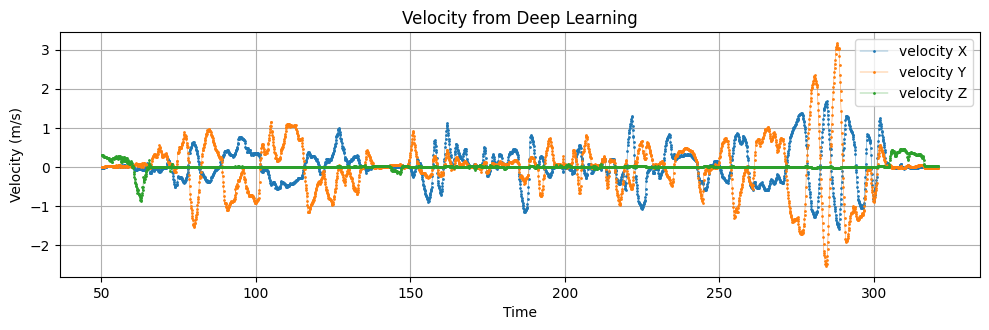

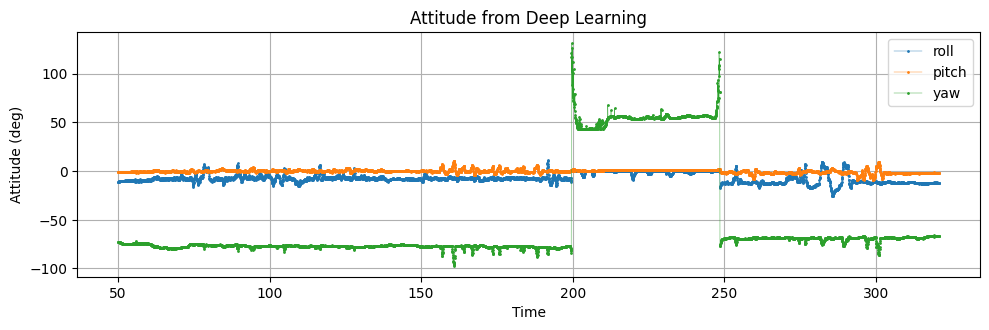

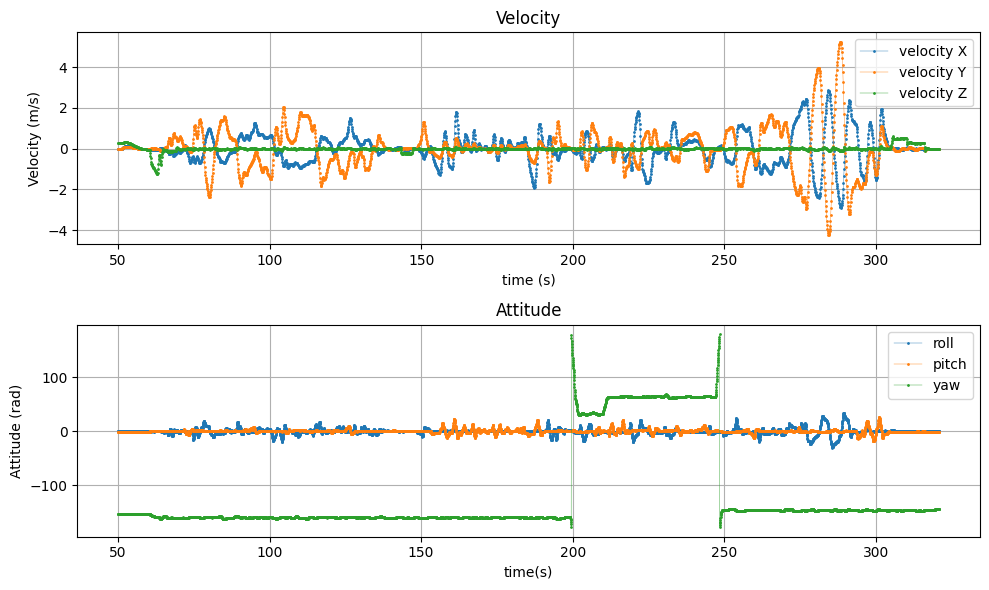

In [53]:
def plot_outputs(outputs, time_data, label_list=['a', 'b', 'c'], ylabel='y', title='Title', subplot=None):
    outputs = outputs.detach().numpy()

    plt.figure(figsize=(10, 6))
    if subplot is not None:
        plt.subplot(subplot)
    plt.plot(time_data, outputs[:, 0], '.-', markersize=2, linewidth=0.3, label=label_list[0])
    plt.plot(time_data, outputs[:, 1], '.-', markersize=2, linewidth=0.3, label=label_list[1])
    plt.plot(time_data, outputs[:, 2], '.-', markersize=2, linewidth=0.3, label=label_list[2])
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def moving_average_filter(data, window_size=10):
    # 데이터가 2D인 경우 각 열에 대해 이동평균 필터 적용
    if len(data.shape) == 2:
        smoothed_data = torch.zeros_like(data)
        for i in range(data.shape[1]):  # 각 열에 대해 이동평균 적용
            cumsum = torch.cumsum(torch.cat((torch.tensor([0.0], device=data.device), data[:, i])), dim=0)
            smoothed_col = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
            smoothed_data[:len(smoothed_col), i] = smoothed_col  # 앞부분은 필터링 데이터로 대체
        return smoothed_data
    # 데이터가 1D인 경우
    cumsum = torch.cumsum(torch.cat((torch.tensor([0.0], device=data.device), data)), dim=0)
    smoothed_data = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return smoothed_data

def low_pass_filter(data, alpha=0.1):
    # 로우패스 필터 적용 (1차 IIR 필터)
    filtered_data = torch.zeros_like(data)
    filtered_data[0] = data[0]  # 초기값 설정
    for i in range(1, len(data)):
        filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
    return filtered_data

inputs_vel = torch.tensor(input_data_vel, dtype=torch.float32)
inputs_att = torch.tensor(input_data_att, dtype=torch.float32)
vel_outputs = velocity_model(inputs_vel)
att_outputs = attitude_model(inputs_att)

# vel_offset = vel_outputs[0, :]
# vel_outputs_corrected = vel_outputs - vel_offset
# print(f"Velocity offset : {vel_offset}")

# att_offset = att_outputs[0, :]
# att_outputs_corrected = att_outputs - att_offset
# print(f"Attitude offset : {att_offset}")

# 필터 적용
# vel_outputs_movemean = moving_average_filter(vel_outputs, window_size=20)
# att_outputs_movemean = moving_average_filter(att_outputs_corrected, window_size=200)
# vel_outputs_lowpass = low_pass_filter(vel_outputs, alpha=0.1)
# att_outputs_lowpass = low_pass_filter(att_outputs_corrected, alpha=0.1)

target_data_vel = torch.tensor(target_data_vel, dtype=torch.float32)
target_data_att = torch.tensor(target_data_att, dtype=torch.float32)
mse_vel = torch.mean((vel_outputs - target_data_vel) ** 2).item() 
mae_vel = torch.mean(torch.abs(vel_outputs - target_data_vel)).item() 
mse_att = torch.mean((att_outputs - target_data_att) ** 2).item() 
mae_att = torch.mean(torch.abs(att_outputs - target_data_att)).item() 

print(f"Velocity - Mean Squared Error (MSE): {mse_vel:.4f}")
print(f"Velocity - Mean Absolute Error (MAE): {mae_vel:.4f}")
print(f"Attitude - Mean Squared Error (MSE): {mse_att:.4f}")
print(f"Attitude - Mean Absolute Error (MAE): {mae_att:.4f}")

# att_outputs[:, 2] = 0

plot_outputs(vel_outputs, time_vel_target, ['velocity X', 'velocity Y', 'velocity Z'], 'Velocity (m/s)', 'Velocity from Deep Learning', 211)
plot_outputs(att_outputs*180/np.pi, time_att_target, ['roll', 'pitch', 'yaw'], 'Attitude (deg)', 'Attitude from Deep Learning', 212)
# plot_outputs(vel_outputs_movemean, time_vel_target, ['velocity X', 'velocity Y', 'velocity Z'], 'Velocity (m/s)', 'Velocity', 211)
# plot_outputs(att_outputs_movemean*180/np.pi, time_att_target, ['roll', 'pitch', 'yaw'], 'Attitude (deg)', 'Attitude', 212)
# plot_outputs(vel_outputs_lowpass, time_vel_target, ['velocity X', 'velocity Y', 'velocity Z'], 'Velocity (m/s)', 'Velocity', 211)
# plot_outputs(att_outputs_lowpass*180/np.pi, time_att_target, ['roll', 'pitch', 'yaw'], 'Attitude (deg)', 'Attitude', 212)
plot_velocity_attitude(velocity_x_target, velocity_y_target, velocity_z_target, time_vel_target, roll_target, pitch_target, yaw_target, time_att_target)

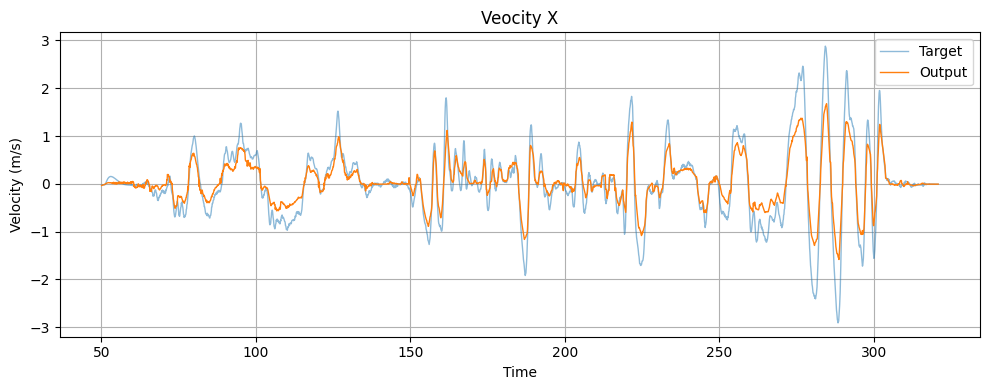

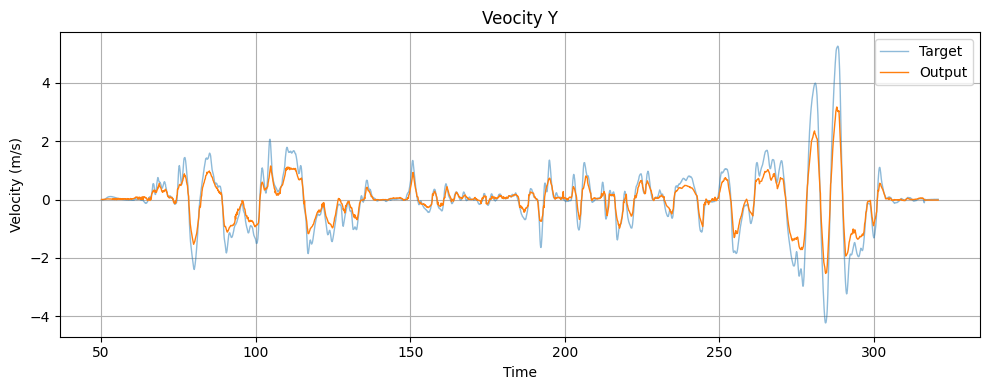

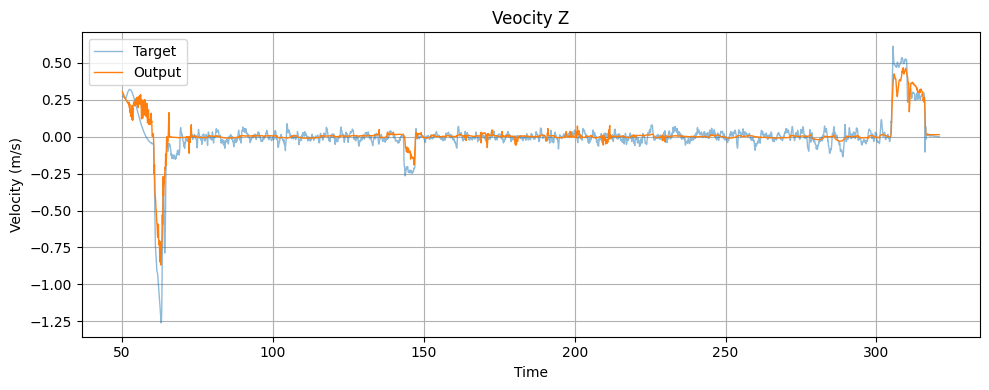

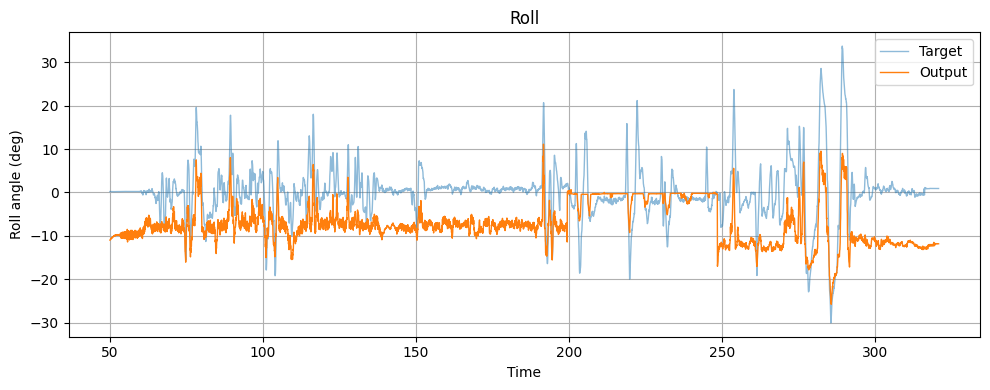

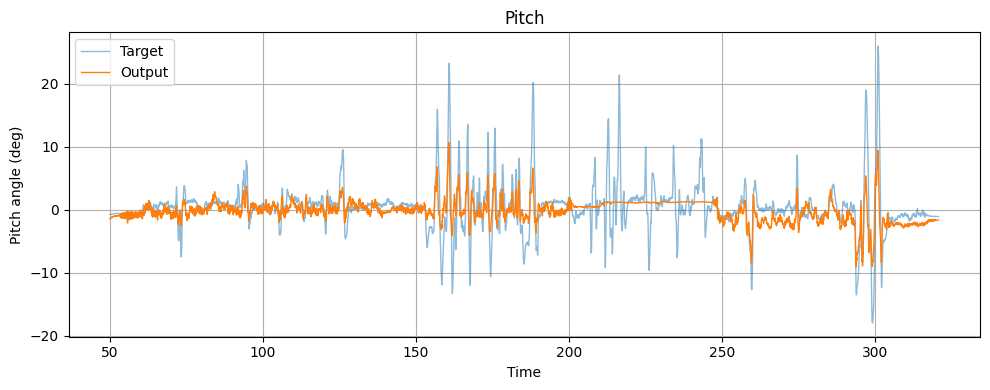

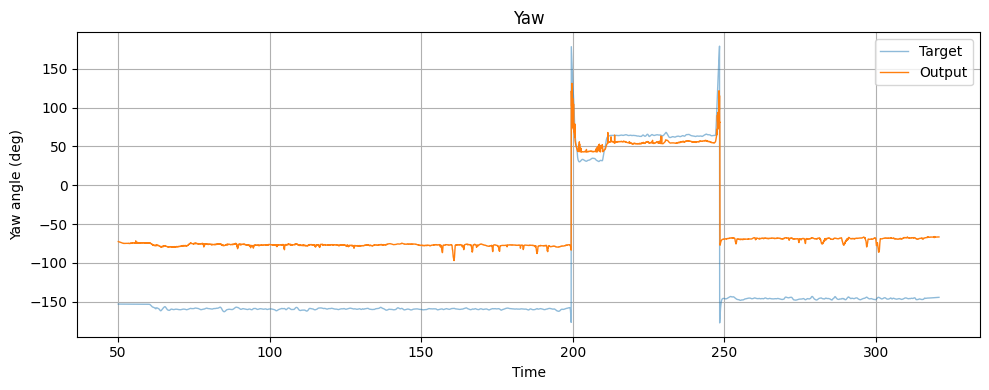

In [54]:
def plot_outputs_compare(outputs, time_outputs, target, time_target, ylabel='y', title='Title', subplot=None):
    outputs = outputs.detach().numpy()

    plt.figure(figsize=(10, 4))
    if subplot is not None:
        plt.subplot(subplot)
    plt.plot(time_target, target, '-', linewidth=1, alpha=0.5, label='Target')
    plt.plot(time_outputs, outputs, '-', linewidth=1, label='Output')
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_outputs_compare(vel_outputs[:, 0], time_vel_target, velocity_x_target, time_vel_target, ylabel='Velocity (m/s)', title='Veocity X')
plot_outputs_compare(vel_outputs[:, 1], time_vel_target, velocity_y_target, time_vel_target, ylabel='Velocity (m/s)', title='Veocity Y')
plot_outputs_compare(vel_outputs[:, 2], time_vel_target, velocity_z_target, time_vel_target, ylabel='Velocity (m/s)', title='Veocity Z')
plot_outputs_compare(att_outputs[:, 0]*180/np.pi, time_att_target, roll_target*180/np.pi, time_att_target, ylabel='Roll angle (deg)', title='Roll')
plot_outputs_compare(att_outputs[:, 1]*180/np.pi, time_att_target, pitch_target*180/np.pi, time_att_target, ylabel='Pitch angle (deg)', title='Pitch')
plot_outputs_compare(att_outputs[:, 2]*180/np.pi, time_att_target, yaw_target*180/np.pi, time_att_target, ylabel='Yaw angle (deg)', title='Yaw')

## Trajectory

In [63]:
def rk4_integrate_velocity(velocities, time, initial_position=np.array([0.0, 0.0, 0.0])):
    velocities = np.array(velocities)
    time = np.array(time)
    initial_position = np.array(initial_position)

    N = len(time)
    positions = np.zeros((N, 3))
    positions[0] = initial_position

    for i in range(1, N):
        dt = time[i] - time[i - 1]
        
        v0 = velocities[i - 1]
        v1 = velocities[i]

        k1 = v0
        k2 = (v0 + v1) / 2
        k3 = (v0 + v1) / 2
        k4 = v1

        dp = (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        positions[i] = positions[i - 1] + dp

    return positions

# Output 위치 계산 (모델 출력)
vel_numpy = vel_outputs.detach().cpu().numpy()
time_numpy = time_vel_target.detach().cpu().numpy() if hasattr(time_vel_target, 'detach') else np.array(time_vel_target)
position_outputs = rk4_integrate_velocity(vel_numpy, time_numpy)

# Target 위치 계산
vel_target = np.stack([velocity_x_target, velocity_y_target, velocity_z_target], axis=1)
position_target = rk4_integrate_velocity(vel_target, time_numpy)

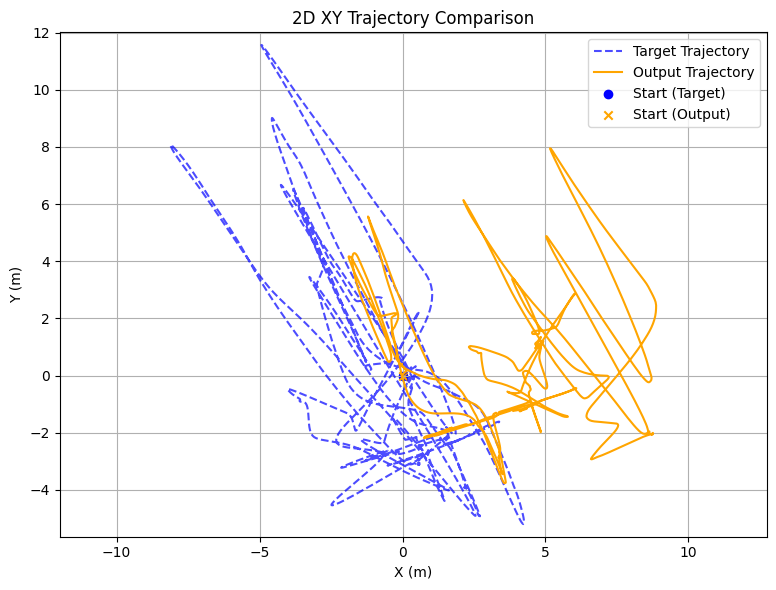

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(position_target[:, 0], position_target[:, 1], label='Target Trajectory', linestyle='--', color='blue', alpha=0.7)
plt.plot(position_outputs[:, 0], position_outputs[:, 1], label='Output Trajectory', color='orange')

plt.scatter(position_target[0, 0], position_target[0, 1], color='blue', marker='o', label='Start (Target)')
plt.scatter(position_outputs[0, 0], position_outputs[0, 1], color='orange', marker='x', label='Start (Output)')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D XY Trajectory Comparison')
plt.legend()
plt.grid(True)
plt.axis('equal') 

plt.tight_layout()
plt.show()